In [6]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from matplotlib.pyplot import figure
import pandas as pd
from scipy import integrate
import numpy.matlib
from scipy.optimize import curve_fit
from scipy.stats import norm
import statistics
from math import comb
from operator import add
plt.style.use("seaborn-v0_8-white")
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 5


## Results of Alternative model from Supplement: Alternative model: Viral Decision

In [8]:
def Model_2(y,t,pars):
    if pars['n'] == 0:
        return ('Need n>0 classes')
    if pars['n'] == 1:
        dy= np.zeros(5)
        R = y[0]
        S = y[1]
        E = y[2]
        I = y[3]
        V = y[4]
        
        psy_R = pars['mu_max'] * (R/(R+pars['R_in']))
        psy_R_dim = (R/(R+pars['sens']*pars['R_in']))/(pars['R0']/(pars['R0']+pars['sens']*pars['R_in']))
        #psy_R_dim =1
        
        dy[0] = pars['J'] - pars['e']* psy_R*(S+E) #R
        dy[1] = psy_R * S  - pars['phi'][0] * S* V +psy_R*E + psy_R*I #S
        dy[2] = pars['phi'][0] * S* V  - pars['lam'][0]*E  #E
        dy[3] = pars['lam'][0]*E - psy_R_dim*(pars['eta'] * I) #I
        dy[4] = psy_R_dim*(pars['bet']*pars['eta'] * I) - (pars['phi'][0]*S + pars['phi'][0]*E)* V #V
        
        return dy  
    else:
        dy = np.zeros(2*pars['n']+3)
        R = y[0]
        S = y[1]
        Pe_1 = y[2]
        Pe_s = y[3:(pars['n']+1)]
        Pe_k = y[pars['n'] + 1]
        Pf_1 = y[pars['n']+2]
        Pf_s = y[(pars['n']+3):(2*pars['n']+1)]
        Pf_k = y[2*pars['n'] + 1]
        V = y[2*pars['n'] + 2]

        Pe_prev = np.concatenate((Pe_1 ,  Pe_s[0:-1]), axis = None)
        Pe_total = np.concatenate((Pe_1 ,  Pe_s, Pe_k), axis = None)
        
        Pe_sum = np.sum(Pe_total)
        
        Pf_prev = np.concatenate((Pf_1 ,  Pf_s[0:-1]), axis = None)
        Pf_total = np.concatenate((Pf_1 ,  Pf_s, Pf_k), axis = None)
        
        Pf_sum = np.sum(Pf_total)

 
        psy_R = pars['mu_max'] * (R/(R+pars['R_in']))
        psy_R_dim = (R/(R+pars['sens']*pars['R_in']))/(pars['R0']/(pars['R0']+pars['sens']*pars['R_in']))

        Pe_topmid = np.concatenate((Pe_1 ,  Pe_s), axis = None)
        Pf_topmid = np.concatenate((Pf_1 ,  Pf_s), axis = None)
  
        
        
        lam_sum = np.sum(pars['lam'])


        dy[0] = pars['J'] - pars['e']* psy_R*(S +(1/(1-pars['alpha_p'])) * ((np.sum(Pe_total))+np.sum(Pf_total))) - pars['dR'] * R #R
        

        dy[1] = psy_R * S  - pars['phi'][0]  * S* V   + 2* psy_R * np.sum(1/(1-pars['alpha_p']) * (pars['fin'][0]*Pe_total)) + 2* psy_R * np.sum(1/(1-pars['alpha_p']) * (pars['fin'][0]*Pf_total)) - pars['dS']*S # S

        dy[2] = pars['phi'][0] * S * V - pars['phi'][1] * Pe_1 * V  -  (pars['lam'][0] * Pe_1) - (psy_R)*Pe_1 + 1/(1-pars['alpha_p'])*2*psy_R*np.sum(pars['fin'][0]*(Pe_total), axis = 0)-  pars['dE'] * Pe_1  #Pe_1

        dy[3:(pars['n']+1)]  = pars['phi'][1:-2] * Pe_prev * V - pars['phi'][2:-1] * Pe_s * V -  (pars['lam'][1:-1] * Pe_s) -(psy_R)*Pe_s + 2*psy_R * np.sum(pars['fin'][1:-1]*Pe_total, axis = 1)/(1-pars['alpha_p'])- pars['dE'] * Pe_s  # Pe_s
        
        dy[pars['n']+1]  = pars['phi'][-1] * Pe_topmid[-1]*V -  (pars['lam'][-1] * Pe_k) -  (psy_R)*Pe_k +  2*psy_R*np.sum(pars['fin'][-1]*(Pe_k), axis = 0)/(1-pars['alpha_p'])-  pars['dE'] * Pe_k  #Pe_K

        dy[pars['n']+2] = pars['lam'][0]*Pe_1 - psy_R_dim * (pars['eta'] * (Pf_1)) -  (psy_R)*Pf_1 + 1/(1-pars['alpha_p'])*2*psy_R*np.sum(pars['fin'][0]*(Pf_total), axis = 0) #Pf_1
        
        dy[(pars['n']+3):(2*pars['n']+1)] = (pars['lam'][1:-1] * Pe_s) - psy_R_dim * (pars['eta'] * (Pf_s)) - (psy_R)*Pf_s + 2*psy_R * np.sum(pars['fin'][1:-1]*Pf_total, axis = 1)/(1-pars['alpha_p']) #Pf_s
        
        dy[2*pars['n'] + 1]= pars['lam'][-1]*Pe_k - psy_R_dim * (pars['eta'] * (Pf_k)) -  (psy_R)*Pf_k +  2*psy_R*np.sum(pars['fin'][-1]*(Pf_k), axis = 0)/(1-pars['alpha_p']) #Pf_k
        
        dy[2*pars['n']+2] = pars['bet']*psy_R_dim * (pars['eta'] * (Pf_sum))- V*(pars['phi'][0] * S + np.sum(pars['phi'][2:-1] * Pe_prev) + pars['phi'][-1] * Pe_topmid[-1]) - pars['dV'] * V #V
        
 
        
        #print(np.sum(pars['bet']*I*pars['eta']))
        #print(psy_R)
        return dy  

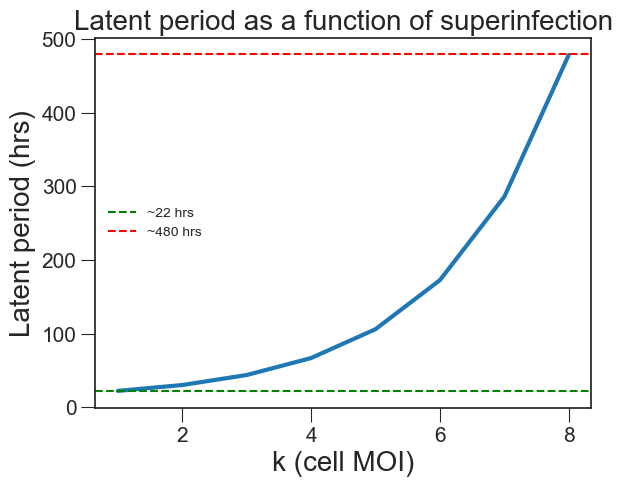

In [9]:
pars={}
lat_per = []
mu_max_vals=[0.06,0.06,0.06,0.06,0.06,0.06]
MOI_vals= [10,5,1,0.1,0.01,0]
colors = ['black','red','fuchsia','orange','turquoise','gold']
mu_max_vals.reverse()
MOI_vals.reverse()
virus_insert_time = 67
pars['n'] = 8
MOI = np.arange(pars['n']) +1
vals = np.arange(pars['n']) 
mat =  [[0]*pars['n']]*pars['n']
per = []
for i in range(len(mat)):
    lst = []
    for j in range(len(mat[i])):
        lst.append(comb(j,i)*(1/(2))**(j+1))
    mat[i] = lst
        
pars['fin'] = np.triu(mat, k=0)

pars['e'] = 0.75*10**-7
pars['mu_max'] = 0.06
pars['R_in'] =8
pars['R0'] = 25


MOI = np.arange(pars['n']) +1 
q = 0
pars['q'] = 1-(1-q)**MOI 

phi_values = []
eta_values = []
lam_values = []
beta_values = []


lam_initial = 1/6.7
pars['eta'] = 1/11
pars['a'] = 1.7
#MOI = np.linspace(0,pars['n'],1000)

MOI = np.arange(pars['n']) +1
#MOI = np.linspace(0,pars['n'],1000)
for i in MOI:
    lam_value =lam_initial/((pars['a'])**i)
    if i<0:
        lam_values.append(lam_initial)
    elif 1/lam_value + 1/pars['eta'] < 550:
        lam_values.append(lam_value)
        threshold_lam = lam_value
    else:
        lam_values.append(threshold_lam)
for i in lam_values:
    lat_per.append(1/i + 1/pars['eta'])



phi_initial = 4*10**-10       
phi_vals = [phi_initial]
for i in (vals+1):
    phi_vals.append(phi_initial)

phi_vals


#MOI = np.linspace(0,pars['n'],1000)


pars['sens']= 0.07
pars['lam'] = lam_values

pars['dR'] = 0
pars['dS'] = 0
pars['dE'] = 0
pars['dL'] = 0
pars['dI'] = 0
pars['dV'] = 0
pars['bet'] = 10
pars['phi'] = phi_vals
pars['alpha_s'] = 0
pars['J'] = 0 
pars['res'] =1
pars['alpha_p'] =0#selective advantage for pseudolysogens in consuming resources

#print('woo')
t0 = 0
tf = virus_insert_time
tstep = 0.1
t = np.arange(t0,tf+tstep,tstep)

plt.plot(MOI,lat_per, linewidth=3.0)
plt.axhline(22, linestyle = '--', color = 'green', label = '~22 hrs')
plt.axhline(480, linestyle = '--', color = 'red', label = '~480 hrs')
plt.ylabel('Latent period (hrs)')
plt.xlabel('k (cell MOI)')
plt.legend()
plt.title('Latent period as a function of superinfection', fontsize =20)
plt.savefig('LP.pdf', bbox_inches = "tight")
plt.show()




## Viral decision model results (Fig S14)

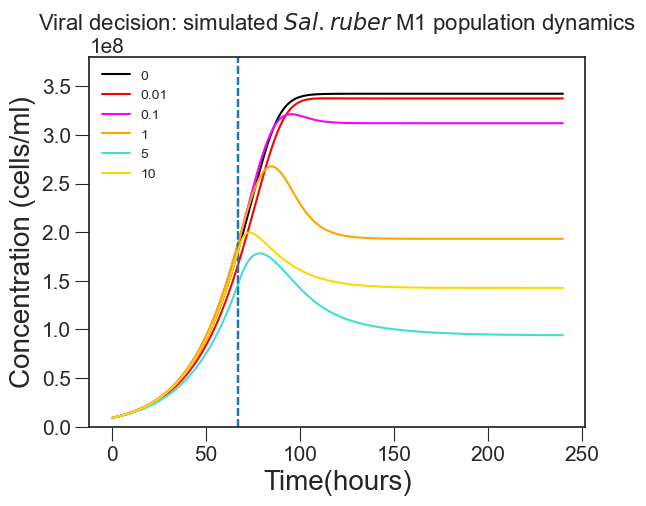

In [11]:
mu_max_vals=[0.062,0.057,0.063,0.063,0.06,0.062]

MOI_vals= [10,5,1,0.1,0.01,0]
colors = ['black','red','fuchsia','orange','turquoise','gold']
mu_max_vals.reverse()
MOI_vals.reverse()
virus_insert_time = 67
Rvals = []
Svals = []

Pf_finals = []
Pe_finals = []


Pe_dist_final=[]
for b in range(len(mu_max_vals)):
    pars['mu_max'] = mu_max_vals[b]
    t0 = 0
    tf = virus_insert_time
    tstep = 0.1
    t = np.arange(t0,tf+tstep,tstep)

    y01 = np.zeros(2*pars['n']+3)
    y01[0] = pars['R0'] #initial resource concentration 
    y01[1] = 9 * 10**6 #initial susceptible concentration 
    y01[-1] = 0#initial free virus concentration 
    y1 = integrate.odeint(Model_2,y01,t,atol = 10**-8,args=(pars,))
    R_0 = y1[:,0]
    S_0 = y1[:,1]
    Pe1_0 = y1[:,2]
    Pe_mid_0 = y1[:,3:(pars['n']+1)]
    Pe_final_0 = y1[:,(pars['n']+1)]
    Pf1_0 = y1[:,pars['n']+2]
    Pf_mid_0 = y1[:,(pars['n']+3):(2*pars['n']+1)]
    Pf_final_0 = y1[:,2*pars['n'] + 1]
    V=y1[:,(2*pars['n']+2)]

    Pe_total_mid_0 = np.sum(Pe_mid_0, axis = 1)
    Pf_total_mid_0 = np.sum(Pf_mid_0, axis = 1)
    Pe_total_0 = np.sum([Pe1_0,Pe_total_mid_0,Pe_final_0], axis = 0)

    Pf_total_0 = np.sum([Pf1_0,Pf_total_mid_0,Pf_final_0], axis = 0)

    host_pop_0 = S_0 + Pe_total_0 + Pf_total_0
    plt.ylabel('Concentration (cells/ml)')
    plt.xlabel('Time(hours)')

    plt.title('S+Pe+Pf+L')
    plt.axvline(virus_insert_time, linestyle = '--')
    plt.plot(t,host_pop_0, color = colors[b])
    Rvals.append(R_0[-1])
    Svals.append(S_0[-1])

    #######
    
    t0 = virus_insert_time
    tf = 240
    tstep = 0.1
    t = np.arange(t0,tf+tstep,tstep)

    y01 = np.zeros(2*pars['n']+3)
    BULK_MOI  = MOI_vals[b]
    y01[0] = Rvals[b] #initial resource concentration 
    y01[1] = Svals[b] #initial susceptible concentration 
    y01[-1] = BULK_MOI * y01[1] #initial free virus concentration 
    #print( y01[1])
    #print(MOI_vals[i])
    y1 = integrate.odeint(Model_2,y01,t,atol = 10**-8,args=(pars,))
    
    R3= y1[:,0]
    S3 = y1[:,1]
    Pe13 = y1[:,2]
    Pe_mid3 = y1[:,3:(pars['n']+1)]
    Pe_final3 = y1[:,(pars['n']+1)]
    Pf13 = y1[:,pars['n']+2]
    Pf_mid3 = y1[:,(pars['n']+3):(2*pars['n']+1)]
    Pf_final3 = y1[:,2*pars['n'] + 1]
    V3=y1[:,(2*pars['n']+2)]

    Pe_total_mid3 = np.sum(Pe_mid3, axis = 1)
    Pf_total_mid3 = np.sum(Pf_mid3, axis = 1)
    Pe_total3 = np.sum([Pe13,Pe_total_mid3,Pe_final3], axis = 0)

    Pf_total3 = np.sum([Pf13,Pf_total_mid3,Pf_final3], axis = 0)

    host_pop3 = S3 + Pe_total3 + Pf_total3
    
    plt.plot(t,host_pop3, color = colors[b], label = str(BULK_MOI))
    plt.ylabel('Concentration (cells/ml)')
    plt.xlabel('Time(hours)')
    plt.title(r'Viral decision: simulated $\it{Sal.ruber}$ M1 population dynamics', fontsize = 16)
    Pe_dist=[]
    Pe_dist.append(Pe13[-1])
    for a in range(len(Pe_mid3[0])):
        Pe_dist.append(Pe_mid3[:,a][-1])
    Pe_dist.append(Pe_final3[-1])
    Pe_dist_final.append(Pe_dist) 
    plt.legend()
    
    Pf_finals.append(Pf_total3)
    Pe_finals.append(Pe_total3)
plt.ylim(0,3.8*10**8)
plt.savefig('Final_result_alternate.pdf',bbox_inches = "tight")
plt.show()





## Viral decision model results without initial growth calibration (same initial uninfected growth independent of MOI)

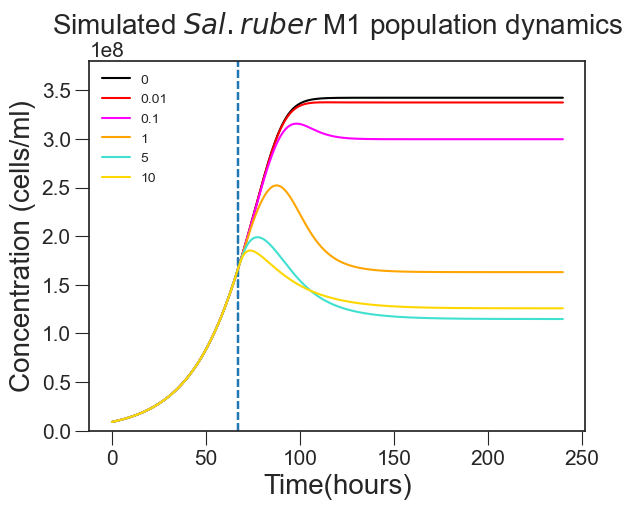

In [22]:
mu_max_vals=[0.06,0.06,0.06,0.06,0.06,0.06]

MOI_vals= [10,5,1,0.1,0.01,0]
colors = ['black','red','fuchsia','orange','turquoise','gold']
mu_max_vals.reverse()
MOI_vals.reverse()
virus_insert_time = 67
Rvals = []
Svals = []

Pf_finals = []
Pe_finals = []


Pe_dist_final=[]
for b in range(len(mu_max_vals)):
    pars['mu_max'] = mu_max_vals[b]
    t0 = 0
    tf = virus_insert_time
    tstep = 0.1
    t = np.arange(t0,tf+tstep,tstep)

    y01 = np.zeros(2*pars['n']+3)
    y01[0] = pars['R0'] #initial resource concentration 
    y01[1] =  9* 10**6 #initial susceptible concentration 
    y01[-1] = 0#initial free virus concentration 
    y1 = integrate.odeint(Model_2,y01,t,atol = 10**-8,args=(pars,))
    R_0 = y1[:,0]
    S_0 = y1[:,1]
    Pe1_0 = y1[:,2]
    Pe_mid_0 = y1[:,3:(pars['n']+1)]
    Pe_final_0 = y1[:,(pars['n']+1)]
    Pf1_0 = y1[:,pars['n']+2]
    Pf_mid_0 = y1[:,(pars['n']+3):(2*pars['n']+1)]
    Pf_final_0 = y1[:,2*pars['n'] + 1]
    V=y1[:,(2*pars['n']+2)]

    Pe_total_mid_0 = np.sum(Pe_mid_0, axis = 1)
    Pf_total_mid_0 = np.sum(Pf_mid_0, axis = 1)
    Pe_total_0 = np.sum([Pe1_0,Pe_total_mid_0,Pe_final_0], axis = 0)

    Pf_total_0 = np.sum([Pf1_0,Pf_total_mid_0,Pf_final_0], axis = 0)

    host_pop_0 = S_0 + Pe_total_0 + Pf_total_0
    plt.ylabel('Concentration (cells/ml)')
    plt.xlabel('Time(hours)')

    plt.title('S+Pe+Pf+L')
    plt.axvline(virus_insert_time, linestyle = '--')
    plt.plot(t,host_pop_0, color = colors[b])
    Rvals.append(R_0[-1])
    Svals.append(S_0[-1])

    #######
    
    t0 = virus_insert_time
    tf = 240
    tstep = 0.1
    t = np.arange(t0,tf+tstep,tstep)

    y01 = np.zeros(2*pars['n']+3)
    BULK_MOI  = MOI_vals[b]
    y01[0] = Rvals[b] #initial resource concentration 
    y01[1] = Svals[b] #initial susceptible concentration 
    y01[-1] = BULK_MOI * y01[1] #initial free virus concentration 
    #print( y01[1])
    #print(MOI_vals[i])
    y1 = integrate.odeint(Model_2,y01,t,atol = 10**-8,args=(pars,))
    
    R3= y1[:,0]
    S3 = y1[:,1]
    Pe13 = y1[:,2]
    Pe_mid3 = y1[:,3:(pars['n']+1)]
    Pe_final3 = y1[:,(pars['n']+1)]
    Pf13 = y1[:,pars['n']+2]
    Pf_mid3 = y1[:,(pars['n']+3):(2*pars['n']+1)]
    Pf_final3 = y1[:,2*pars['n'] + 1]
    V3=y1[:,(2*pars['n']+2)]

    Pe_total_mid3 = np.sum(Pe_mid3, axis = 1)
    Pf_total_mid3 = np.sum(Pf_mid3, axis = 1)
    Pe_total3 = np.sum([Pe13,Pe_total_mid3,Pe_final3], axis = 0)

    Pf_total3 = np.sum([Pf13,Pf_total_mid3,Pf_final3], axis = 0)

    host_pop3 = S3 + Pe_total3 + Pf_total3
    
    plt.plot(t,host_pop3, color = colors[b], label = str(BULK_MOI))
    plt.ylabel('Concentration (cells/ml)')
    plt.xlabel('Time(hours)')
    plt.title(r'Simulated $\it{Sal.ruber}$ M1 population dynamics', fontsize = 20)
    Pe_dist=[]
    Pe_dist.append(Pe13[-1])
    for a in range(len(Pe_mid3[0])):
        Pe_dist.append(Pe_mid3[:,a][-1])
    Pe_dist.append(Pe_final3[-1])
    Pe_dist_final.append(Pe_dist) 
    plt.legend()
    
    Pf_finals.append(Pf_total3)
    Pe_finals.append(Pe_total3)
plt.ylim(0,3.8*10**8)
plt.show()



